## Download MNIST dataset 

In [2]:
import torchvision.datasets as datasets
import numpy as np

mnist_trainset = datasets.MNIST(root='./datasets', train=True, download=True, transform=None)
X_train = np.array(mnist_trainset.data[..., np.newaxis]).transpose(0, 3, 1, 2) / 255
X_train = X_train.astype('float32')
print("Dataset size : ", X_train.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 196901308.28it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 112058921.21it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 78227871.06it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7731545.77it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset size :  (60000, 1, 28, 28)


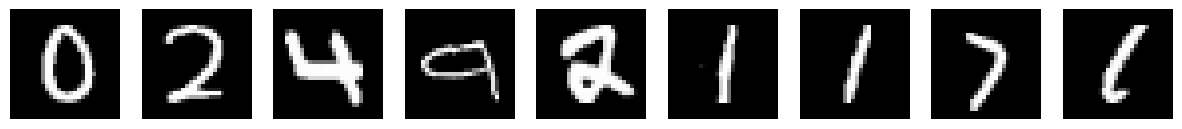

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (15,70))
for i in range(9):
  plt.subplot(1, 9, i+1)
  plt.imshow(X_train[np.random.randint(len(X_train))].transpose((1, 2, 0)), cmap='gray')
  plt.axis('off')
plt.show()

## Generator and Discriminator network

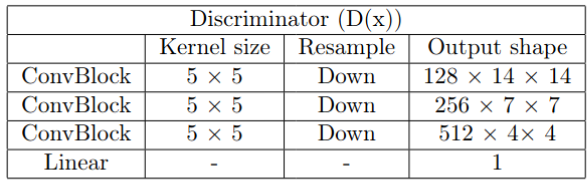

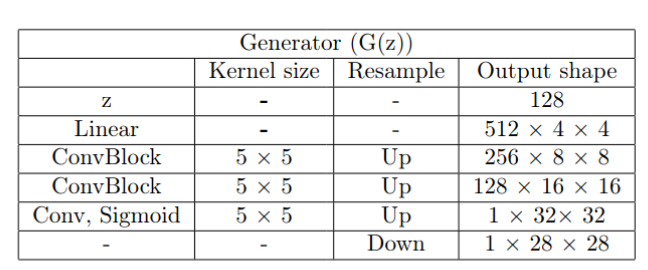

In [9]:
!pip -q install torchviz torchinfo

  Preparing metadata (setup.py) ... done


In [10]:
import torch

from torchviz import make_dot
from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
from wgan_mnist_model import Discriminator, Generator

discriminator = Discriminator().to(device)
generator = Generator().to(device)

In [ ]:
summary(discriminator, input_size=(32, 1, 28, 28))

In [ ]:
summary(generator, input_size=(32, 128))

torch.Size([2, 1, 28, 28])
torch.Size([2, 1])


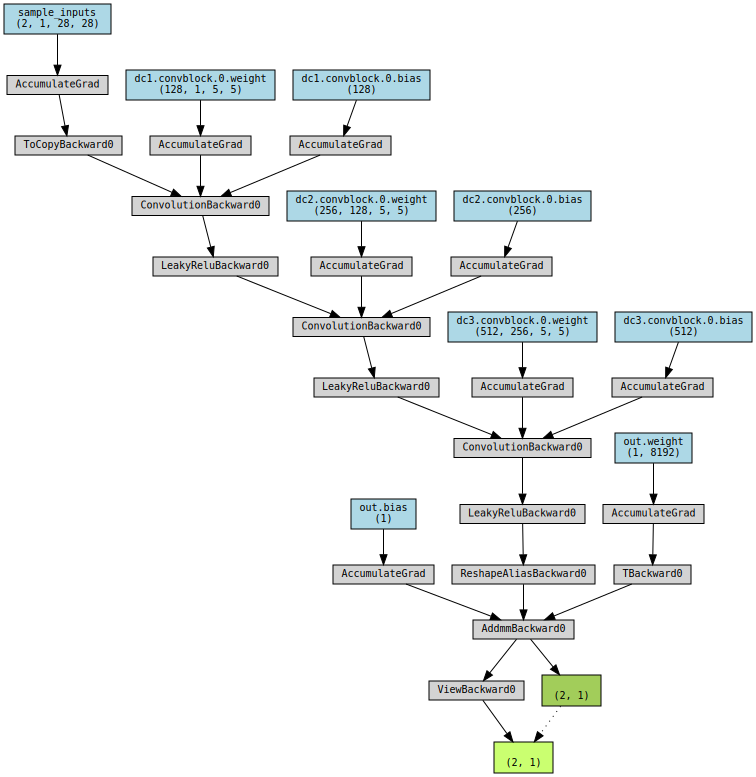

In [15]:
sample_inputs = torch.from_numpy(X_train[:2]).requires_grad_(True)
sample_outputs = discriminator(sample_inputs.to(device))

print(sample_inputs.shape)
print(sample_outputs.shape)
make_dot(sample_outputs, params=dict(list(discriminator.named_parameters()) + [('sample_inputs', sample_inputs)]))

torch.Size([2, 128])
torch.Size([2, 1, 28, 28])


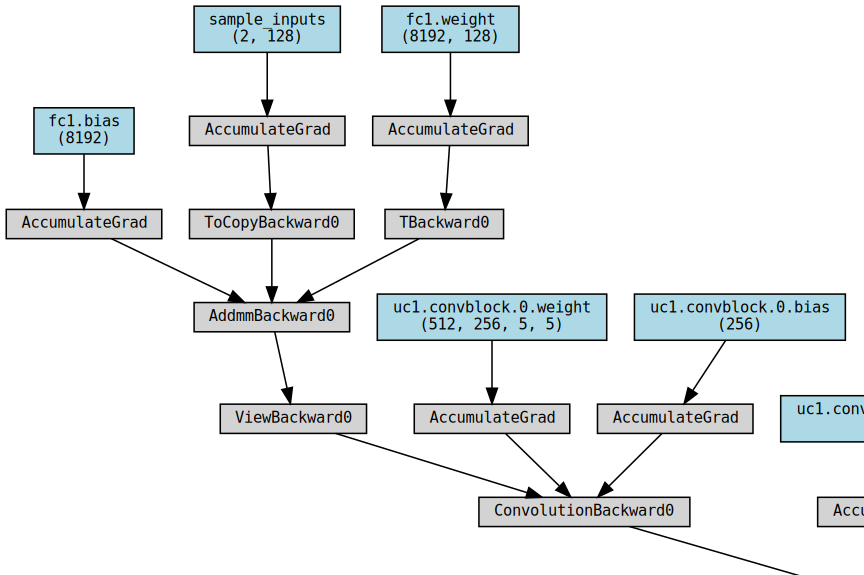

In [16]:
sample_inputs2 = sample_outputs.detach().cpu()
sample_inputs2 = (torch.randn(sample_inputs2.shape[0], 128) * sample_inputs2).requires_grad_(True)
sample_outputs2 = generator(sample_inputs2.to(device))


print(sample_inputs2.shape)
print(sample_outputs2.shape)
make_dot(sample_outputs2, params=dict(list(generator.named_parameters()) + [('sample_inputs', sample_inputs2)]))

In [ ]:
def lr_schedule(i):
  lr = 1e-4
  if i > 6000:
    lr *= 0.01
  elif i > 4000:
    lr *= 0.1

  return lr

In [60]:
NUM_ITERATION = 7000
BATCH_SIZE = 64
fixed_z = torch.randn((8, 128)).to(device)

losses = {'discriminator': [], 'generator': []}

discriminator = Discriminator().to(device)
generator = Generator().to(device)
G_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0., 0.9))
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0., 0.9))
GP_lambda = 10
n_critic = 5

## Data preparation

In [61]:
from torch.utils.data import DataLoader
from wgan_mnist_dataset import GANInput

train_dataset = GANInput(X_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
train_iter_loader = iter(train_loader)

In [62]:
train_dataset[10][0].shape, train_dataset[10][1].shape 

((1, 28, 28), torch.Size([128]))

  0%|          | 0/7000 [00:00<?, ?it/s]

5.293816394572734 2.4563465118408203


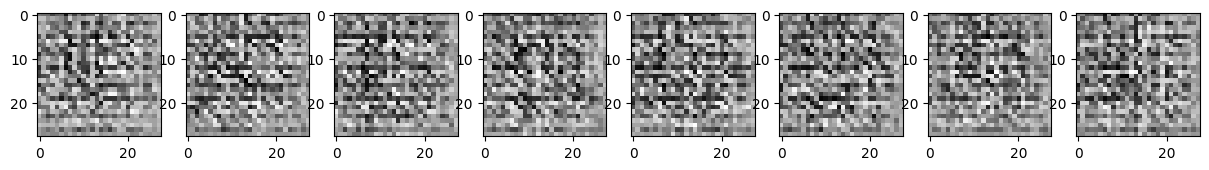

  4%|▍         | 300/7000 [02:18<52:11,  2.14it/s]

-1.774914162902495 -6.04541015625


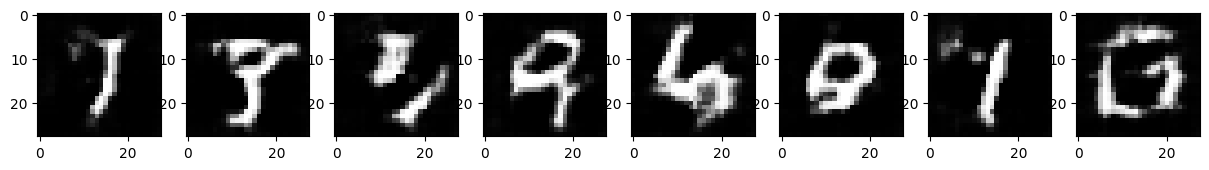

  9%|▊         | 600/7000 [04:40<50:46,  2.10it/s]

-1.58210094537867 -4.741353988647461


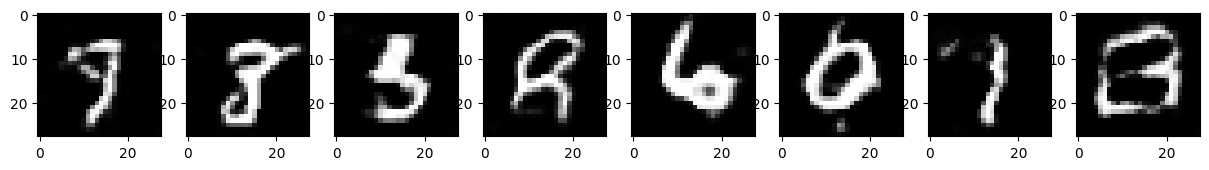

 13%|█▎        | 900/7000 [07:04<48:29,  2.10it/s]

-1.863383029881916 -1.042682409286499


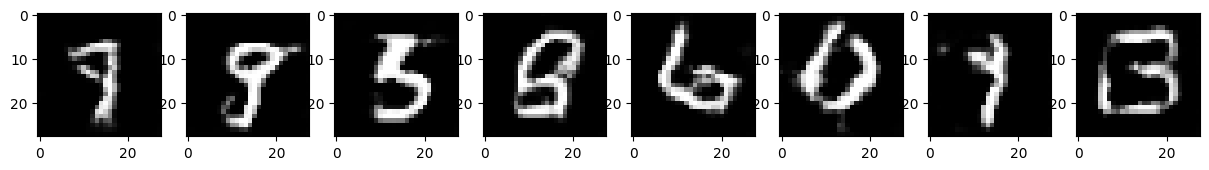

 17%|█▋        | 1200/7000 [09:28<46:03,  2.10it/s]

-1.501393212917987 0.1197643056511879


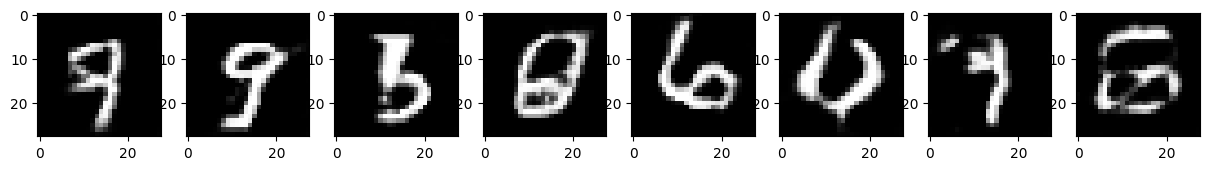

 21%|██▏       | 1500/7000 [11:52<43:51,  2.09it/s]

-1.2837838213515393 1.0919407606124878


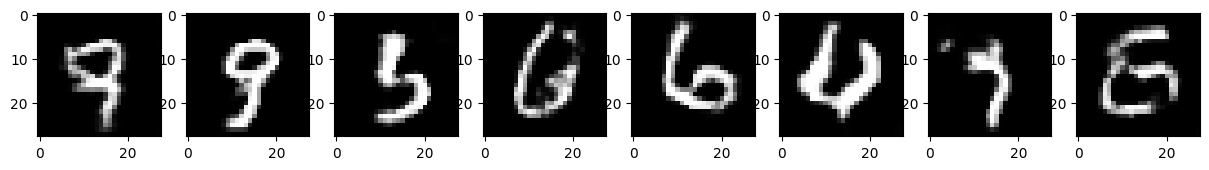

 26%|██▌       | 1800/7000 [14:16<41:17,  2.10it/s]

-1.212757344938696 1.7006080150604248


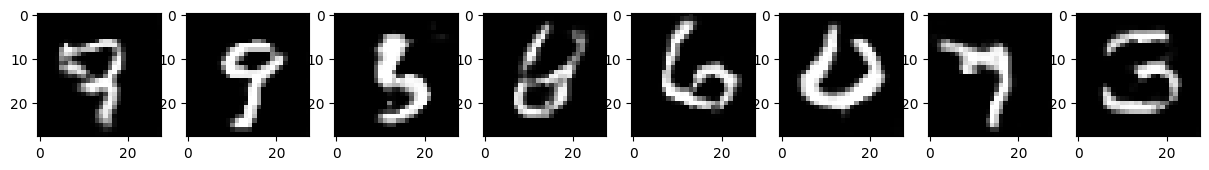

 30%|███       | 2100/7000 [16:40<38:47,  2.10it/s]

-1.5173716660847298 1.4501630067825317


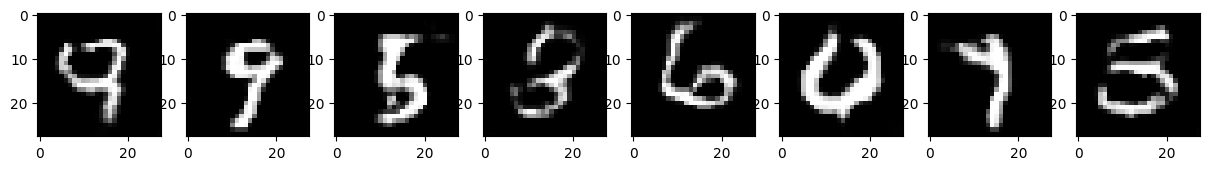

 34%|███▍      | 2400/7000 [19:04<36:17,  2.11it/s]

-1.380222874512945 2.8735909461975098


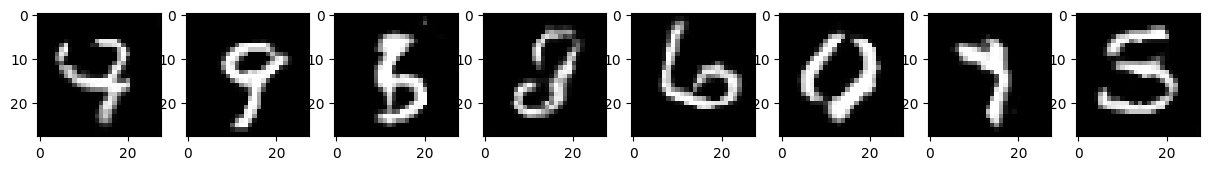

 39%|███▊      | 2700/7000 [21:27<34:05,  2.10it/s]

-1.6128560150017082 1.669000506401062


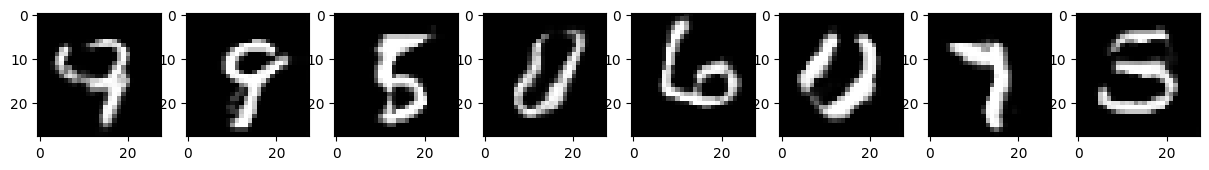

 43%|████▎     | 3000/7000 [23:50<31:37,  2.11it/s]

-1.5063908613931427 1.644425868988037


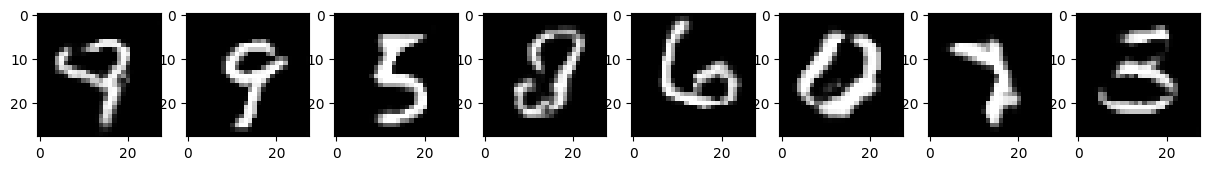

 47%|████▋     | 3300/7000 [26:14<29:22,  2.10it/s]

-1.65732512486034 0.5791764855384827


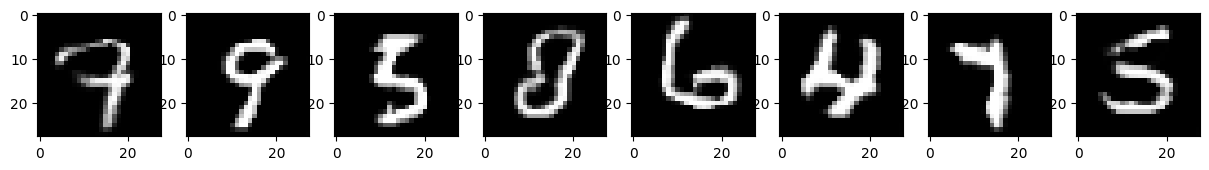

 51%|█████▏    | 3600/7000 [28:38<27:10,  2.09it/s]

-1.188617055125318 1.8690565824508667


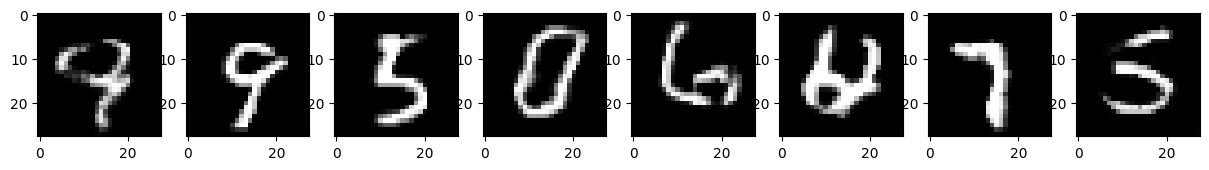

 56%|█████▌    | 3900/7000 [31:02<24:38,  2.10it/s]

-1.5626831834241979 1.3530217409133911


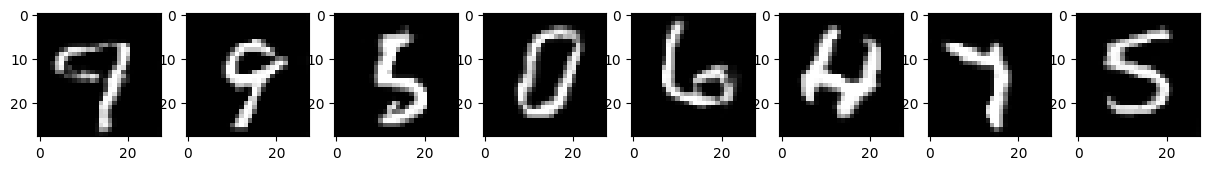

 60%|██████    | 4200/7000 [33:26<22:09,  2.11it/s]

-1.2897959600516042 1.6165273189544678


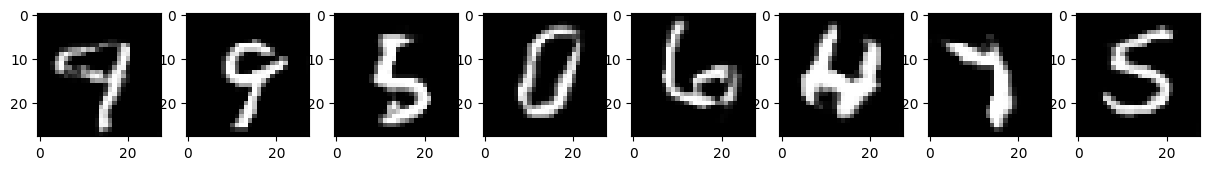

 64%|██████▍   | 4500/7000 [35:49<19:44,  2.11it/s]

-1.3765949217689641 1.9672207832336426


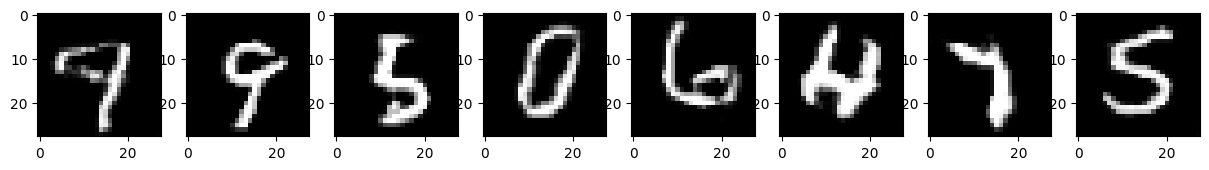

 69%|██████▊   | 4800/7000 [38:12<17:22,  2.11it/s]

-1.3037179247132529 2.0591835975646973


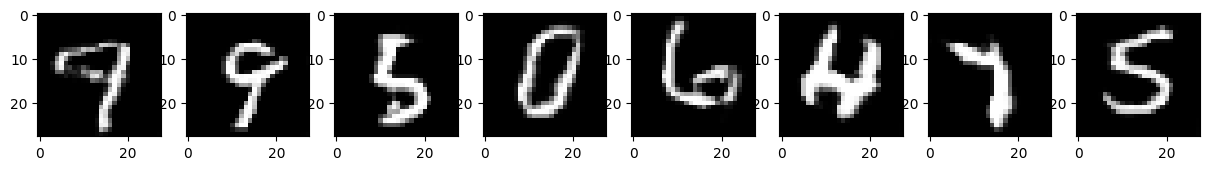

 73%|███████▎  | 5100/7000 [40:36<14:58,  2.12it/s]

-1.202009382419393 2.136613368988037


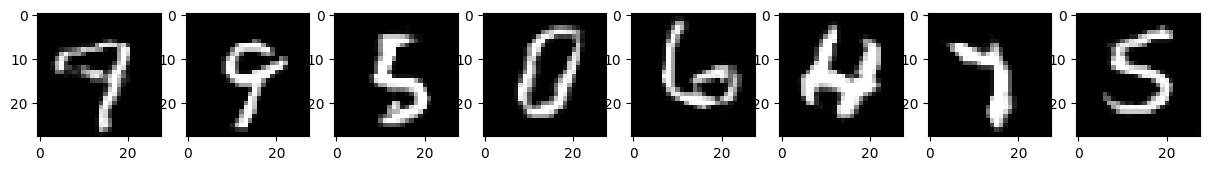

 77%|███████▋  | 5400/7000 [43:00<12:49,  2.08it/s]

-1.301764845124062 2.220367193222046


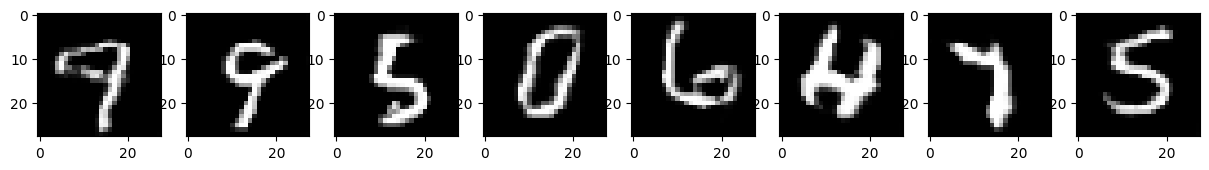

 81%|████████▏ | 5700/7000 [45:24<10:19,  2.10it/s]

-1.1546988519885497 1.8649215698242188


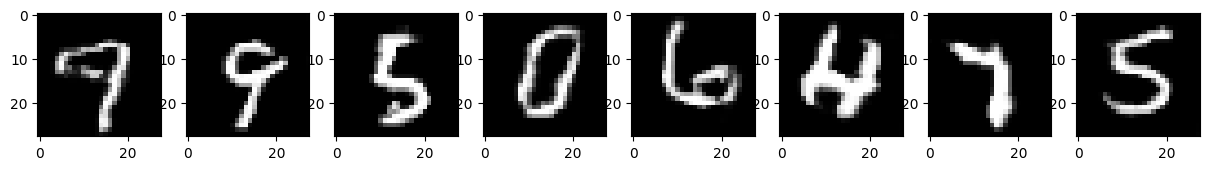

 86%|████████▌ | 6000/7000 [47:48<07:55,  2.10it/s]

-1.275412380898833 2.197279691696167


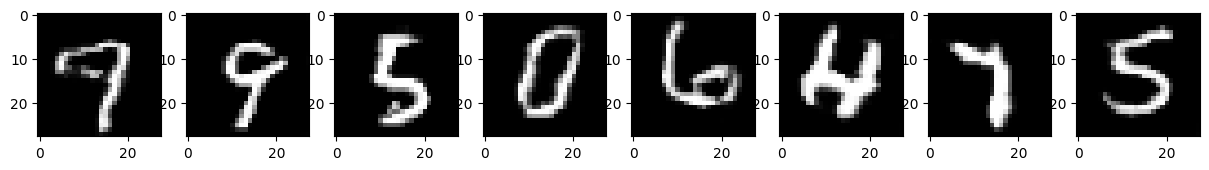

 90%|█████████ | 6300/7000 [50:11<05:35,  2.08it/s]

-1.11085920527263 2.261213779449463


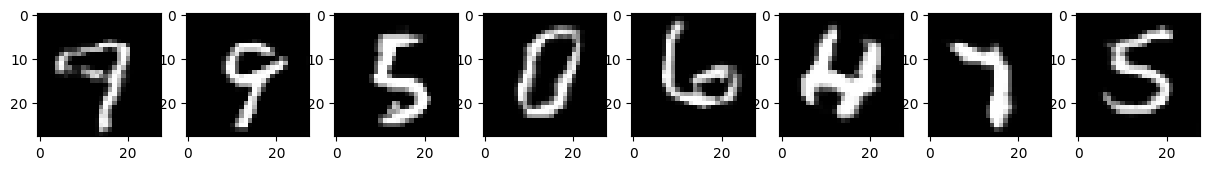

 94%|█████████▍| 6600/7000 [52:35<03:11,  2.09it/s]

-1.1734325399052044 2.192948818206787


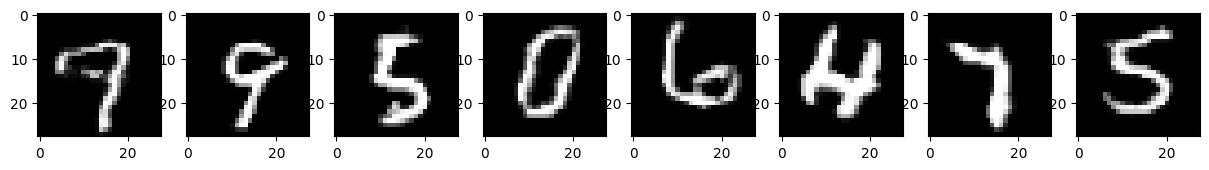

 99%|█████████▊| 6900/7000 [55:00<00:47,  2.10it/s]

-1.34722122547309 2.1120176315307617


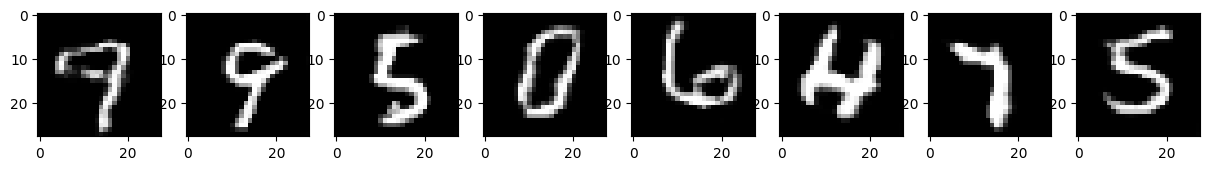

100%|██████████| 7000/7000 [55:48<00:00,  2.09it/s]


In [64]:
from tqdm import tqdm
from calc_gradient_penalty import calc_gradient_penalty


for i in tqdm(range(NUM_ITERATION)):
  # lr scheduling
  lr = lr_schedule(i)
  for param_group in G_optimizer.param_groups:
    param_group['lr'] = lr
  for param_group in D_optimizer.param_groups:
    param_group['lr'] = lr


  for t in range(n_critic):
    # sample the data
    try:
      real_x, z, epsilon = next(train_iter_loader)
    except StopIteration:
      train_iter_loader = iter(train_loader)
      real_x, z, epsilon = next(train_iter_loader)
    real_x, z, epsilon = real_x.to(device), z.to(device), epsilon.to(device)

    # get critic scores
    generated_x = generator(z)
    real_score = discriminator(real_x).mean()
    generated_score = discriminator(generated_x).mean()

    # update critic
    discriminator.zero_grad()

    gradient_penalty = calc_gradient_penalty(discriminator, real_x, generated_x, epsilon, GP_lambda)
    # print('GP shape:', gradient_penalty.shape)
    loss = generated_score - real_score + gradient_penalty
    loss.backward()
    D_optimizer.step()
    losses['discriminator'].append(loss.item())


  # update generator
  generator.zero_grad()

  z = torch.randn(BATCH_SIZE, 128).to(device)
  score = (-1) * discriminator(generator(z)).mean()
  score.backward()
  G_optimizer.step()
  losses['generator'].append(score.item())


  # output visualization
  if i % 300 == 0:
    plt.figure(figsize = (15,75))
    print(losses['discriminator'][-1], losses['generator'][-1])
    with torch.no_grad():
      res = generator(fixed_z).cpu().detach().numpy()
    for k in range(8):
      plt.subplot(1, 8, k+1)
      plt.imshow(res[k].transpose(1, 2, 0)[..., 0], cmap='gray')
    plt.show()